In [ ]:
# !pip install datasets

In [52]:
from datasets import load_dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from torch.utils.data import random_split
import numpy as np

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
label_columns = ['related', 'PII', 'request', 'offer', 'aid_related', 'medical_help',
                 'medical_products', 'search_and_rescue', 'security', 'military',
                 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
                 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related',
                  'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops',
                 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm',
                 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']
num_labels = len(label_columns)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_for_bert(data):
    # Tokenize the messages and prepare the labels
    input_ids = []
    attention_masks = []
    labels = []

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i]['message'],
            add_special_tokens=True,
            max_length=128,  # Adjust as needed
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append([data[i][label] for label in label_columns])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.float)

    return input_ids, attention_masks, labels
dataset = load_dataset("disaster_response_messages")
# Apply preprocessing
train_input_ids, train_attention_masks, train_labels = preprocess_for_bert(dataset['train'])
val_input_ids, val_attention_masks, val_labels = preprocess_for_bert(dataset['validation'])
test_input_ids, test_attention_masks, test_labels = preprocess_for_bert(dataset['test'])

In [54]:
from torch.utils.data import TensorDataset

batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
validation_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)
validation_sampler = torch.utils.data.SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = torch.utils.data.SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [55]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_layers_to_freeze = 190
for i, param in enumerate(model.parameters()):
    if i < num_layers_to_freeze:
        param.requires_grad = False
    else:
        break

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 50  # Adjust as needed
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)
loss_fn = torch.nn.BCEWithLogitsLoss()

c:\Users\GJK\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [57]:
def multilabel_accuracy(preds, labels, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == labels).float()
    acc = correct.sum() / correct.numel()
    return acc
    accuracy = multilabel_accuracy(outputs.logits, batch_labels)

In [58]:
def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_accuracy = 0, 0

    for batch in dataloader:
        inputs, attention_masks, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids=inputs, attention_mask=attention_masks)
            loss = loss_fn(outputs.logits, labels)
            acc = multilabel_accuracy(outputs.logits, labels)

        total_loss += loss.item()
        total_accuracy += acc.item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_accuracy / len(dataloader)
    return avg_loss, avg_acc





In [59]:
trainloss_history = []
valiloss_history = []
min_val_loss = np.inf
pateince_counter = 0
for epoch in range(epochs):
    model.train()
    total_loss, total_accuracy = 0, 0
    
    for batch in train_dataloader:
        inputs, attention_masks, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        optimizer.zero_grad()

        outputs = model(input_ids=inputs, attention_mask=attention_masks)


        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        acc = multilabel_accuracy(outputs.logits, labels)

        total_loss += loss.item()
        total_accuracy += acc.item()


    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_acc = total_accuracy / len(train_dataloader)
    trainloss_history.append(avg_train_loss)
    
    
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc:.4f}")


    val_loss, val_accuracy = validate(model, validation_dataloader, loss_fn, device)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    valiloss_history.append(val_loss)
    #early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
    else:
        pateince_counter += 1
        if pateince_counter > 5:
            break
    
    


Epoch 1/50 - Loss: 0.1922, Accuracy: 0.9352
Epoch 2/50 - Loss: 0.1572, Accuracy: 0.9446
Epoch 3/50 - Loss: 0.1498, Accuracy: 0.9466
Epoch 4/50 - Loss: 0.1445, Accuracy: 0.9480
Epoch 5/50 - Loss: 0.1413, Accuracy: 0.9488
Epoch 6/50 - Loss: 0.1381, Accuracy: 0.9497
Epoch 7/50 - Loss: 0.1351, Accuracy: 0.9506
Epoch 8/50 - Loss: 0.1327, Accuracy: 0.9514
Epoch 9/50 - Loss: 0.1297, Accuracy: 0.9522
Epoch 10/50 - Loss: 0.1275, Accuracy: 0.9527
Epoch 11/50 - Loss: 0.1247, Accuracy: 0.9534
Epoch 12/50 - Loss: 0.1219, Accuracy: 0.9542
Epoch 13/50 - Loss: 0.1196, Accuracy: 0.9547


In [49]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_accuracy = 0, 0

    for batch in dataloader:
        inputs, attention_masks, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids=inputs, attention_mask=attention_masks)
            loss = loss_fn(outputs.logits, labels)
            acc = multilabel_accuracy(outputs.logits, labels)

        total_loss += loss.item()
        total_accuracy += acc.item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_accuracy / len(dataloader)
    return avg_loss, avg_acc

# Example usage after completing all training epochs
test_loss, test_accuracy = test(model, test_dataloader, loss_fn, device)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Test Loss: 0.13133521463834877, Test Accuracy: 0.9570229559233694


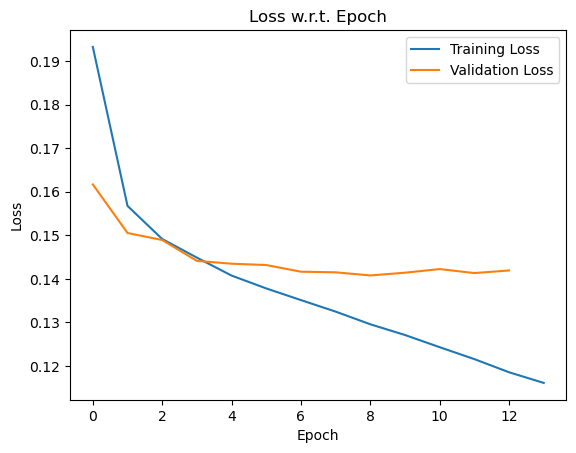

In [50]:
import matplotlib.pyplot as plt
import copy
TL = copy.deepcopy(trainloss_history)
VL = copy.deepcopy(valiloss_history)
L = [TL,VL]
fig0 = plt.figure(0)
for i, loss in enumerate(L):
    if i == 0:
        plt.plot(loss, label='Training Loss')
    if i == 1:
        plt.plot(loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss w.r.t. Epoch')
plt.legend()
plt.show()

In [30]:
torch.save(model.state_dict(), 'basemodel.pt')

In [ ]:
basemodel = BertForSequenceClassification.load_state_dict(torch.load('basemodel.pt'))
for layer in basemodel.layers[:]:  # n is the number of layers to freeze
    layer.trainable = False